<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2714 entries, 0 to 2713
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype    
---  ------               --------------  -----    
 0   month                2714 non-null   period[M]
 1   borough              2714 non-null   object   
 2   communitydistrict    2714 non-null   int64    
 3   refusetonscollected  2714 non-null   float64  
 4   papertonscollected   2714 non-null   float64  
 5   mgptonscollected     2714 non-null   float64  
 6   resorganicstons      1474 non-null   float64  
 7   schoolorganictons    1220 non-null   float64  
 8   leavesorganictons    84 non-null     float64  
 9   xmastreetons         145 non-null    float64  
 10  otherorganicstons    461 non-null    float64  
 11  borough_id           2714 non-null   int64    
 12  month_2              2714 non-null   int64    
 13  year                 2714 non-null   int64    
dtypes: float64(8), int64(4), object(1), period[M](1)
memory 

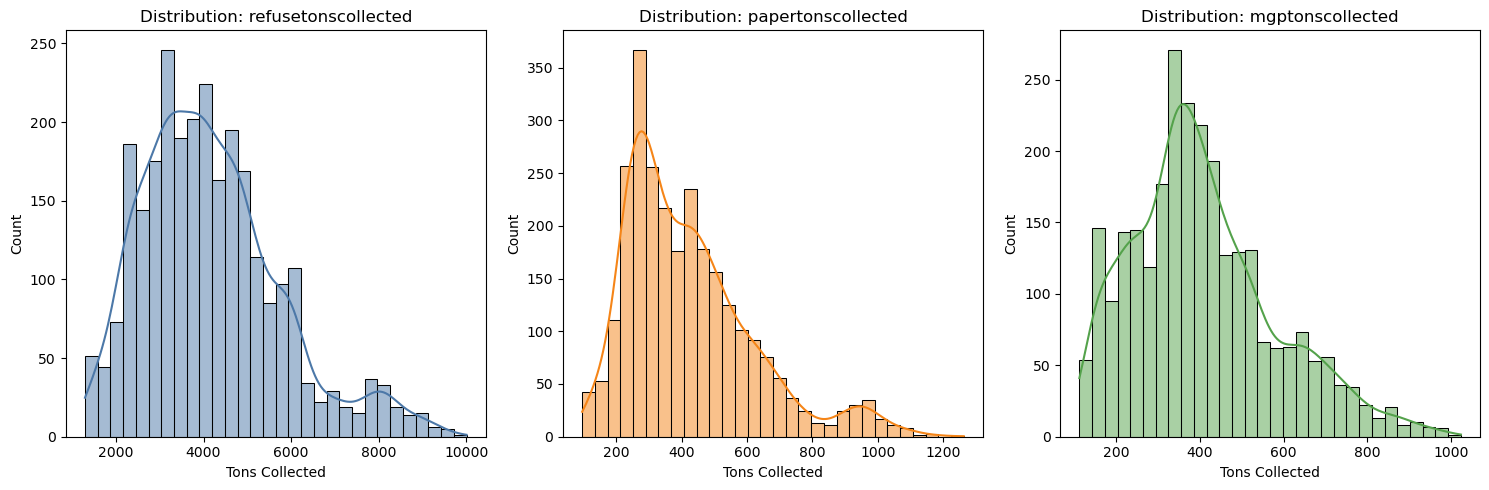

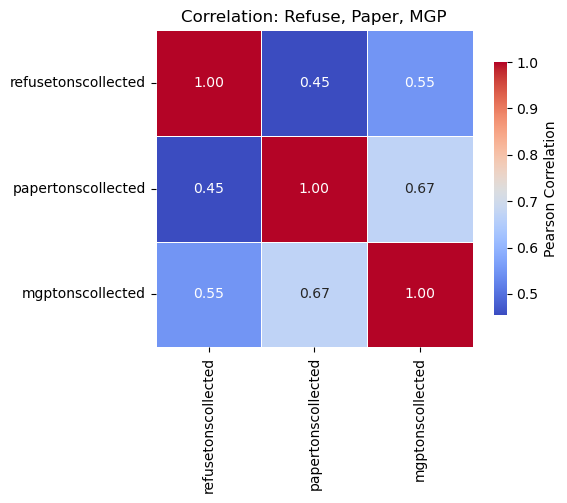

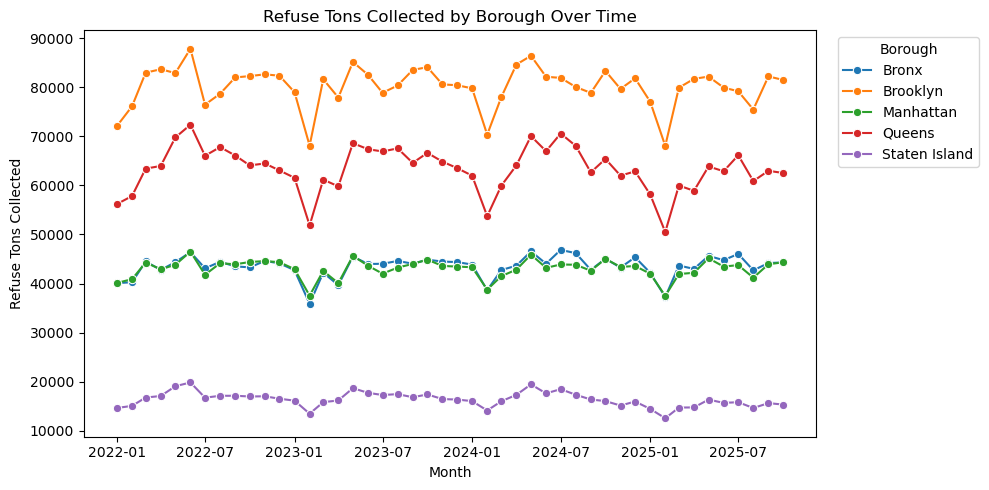

Average refuse tons per year: 2,833,290

Annual refuse collection:
year
2022    2992123.2
2023    2956235.0
2024    2981810.7
2025    2402991.6
Name: refusetonscollected, dtype: float64
Missing population after merge: 0

Target Distribution:
high_recycling
0    2011
1     703
Name: recycling_ratio, dtype: int64


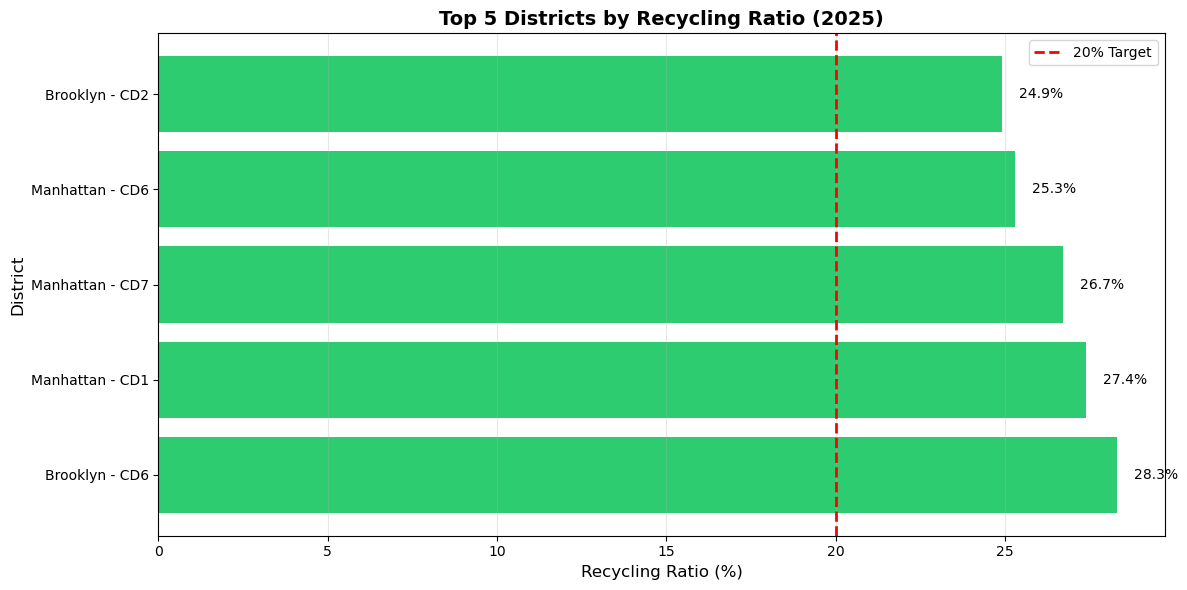

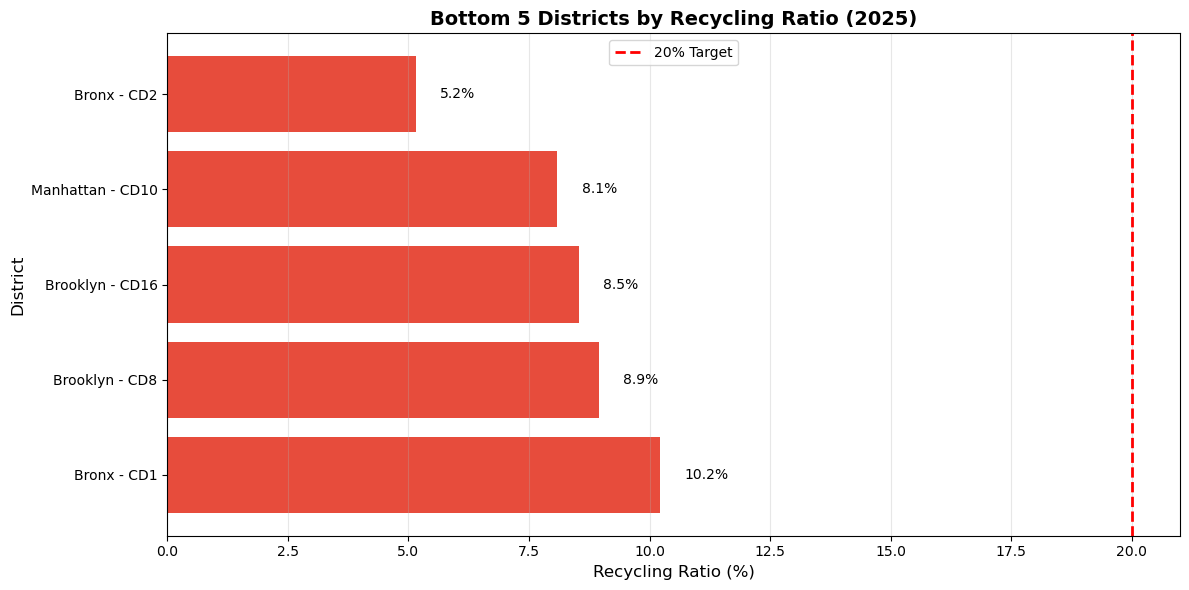


Datasets exported:
  - models_data.csv: (2714, 9)
  - model_2_data.csv: (2714, 13)

FINAL DATASET SUMMARY
Total rows: 2,714
Date range: 2022-01 to 2025-10
Boroughs: 5
Districts: 18

Features engineered: 26

Key features:
  - refuse_lag1
  - refuse_lag12
  - recycling_ratio
  - high_recycling
  - refuse_per_capita_2010


In [3]:
# =====================================================
# NYC WASTE DATA ANALYSIS & FEATURE ENGINEERING
# =====================================================

# =============================================================================
# 1. SETUP & DATA LOADING
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dataprep.eda import create_report

# Load data
path = '/Users/Marcy_Student/Desktop/marcy/Modeling NYC-waste/Data/DSNY_Monthly_Tonnage_Data_20251208.csv'
df = pd.read_csv(path)

# =============================================================================
# 2. DATA CLEANING
# =============================================================================
# Parse date column
df['MONTH'] = pd.to_datetime(df['MONTH'])
df['MONTH'] = df['MONTH'].dt.to_period('M')

# Clean column names: lowercase and trim
df.columns = df.columns.str.lower().str.strip()

# Extract temporal features
df['month_2'] = df['month'].dt.month  # Month number (1-12)
df['year'] = df['month'].dt.year

# Check data types
df.info()

# =============================================================================
# 3. EXPLORATORY DATA ANALYSIS
# =============================================================================

# --- 3.1 Distribution Analysis ---
# Histograms of main waste types
cols = ['refusetonscollected', 'papertonscollected', 'mgptonscollected']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, col, color in zip(axes, cols, ['#4c78a8', '#f58518', '#54a24b']):
    sns.histplot(df[col], bins=30, kde=True, color=color, ax=ax)
    ax.set_title(f'Distribution: {col}')
    ax.set_xlabel('Tons Collected')
    ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

# --- 3.2 Correlation Analysis ---
corr_matrix = df[cols].corr(method='pearson')

plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", 
            linewidths=0.5, square=True,
            cbar_kws={'shrink': 0.8, 'label': 'Pearson Correlation'})
plt.title('Correlation: Refuse, Paper, MGP')
plt.tight_layout()
plt.show()

# --- 3.3 Time Series Analysis ---
# Aggregate by month and borough
monthly_borough = df.groupby(['month', 'borough'])[cols].sum().reset_index()
monthly_borough['month_ts'] = monthly_borough['month'].dt.to_timestamp()

plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_borough.sort_values('month_ts'),
             x='month_ts', y='refusetonscollected',
             hue='borough', marker='o')
plt.title('Refuse Tons Collected by Borough Over Time')
plt.xlabel('Month')
plt.ylabel('Refuse Tons Collected')
plt.legend(title='Borough', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

# --- 3.4 Annual Statistics ---
annual_refuse = df.groupby('year')['refusetonscollected'].sum()
avg_annual_refuse = annual_refuse.mean()

print(f"Average refuse tons per year: {avg_annual_refuse:,.0f}")
print("\nAnnual refuse collection:")
print(annual_refuse.sort_index())

# =============================================================================
# 4. FEATURE ENGINEERING
# =============================================================================

# --- 4.1 Aggregate Minor Waste Categories ---
df['other_tonnage'] = df[['resorganicstons', 'schoolorganictons', 
                           'otherorganicstons', 'xmastreetons']].sum(axis=1)

# --- 4.2 Lag Features (Time Series) ---
# Sort for proper lag computation
df = df.sort_values(['borough', 'communitydistrict', 'month'])

# Lag-1 features (previous month)
for col in ['refusetonscollected', 'papertonscollected', 'mgptonscollected', 'other_tonnage']:
    lag_col = f"{col.replace('tonscollected', '')}_lag1".replace('collected', '_lag1')
    df[lag_col] = (
        df.groupby(['borough', 'communitydistrict'])[col]
          .shift(1)
    )

# Lag-12 features (same month last year)
df['refuse_lag12'] = (
    df.groupby(['borough', 'communitydistrict'])['refusetonscollected']
      .shift(12)
)

# Fill NaN lags with group means or current values
df['refuse_lag12'] = df['refuse_lag12'].fillna(
    df.groupby(['borough', 'month_2'])['refusetonscollected'].transform('mean')
)
df['refuse_lag1'] = df['refuse_lag1'].fillna(df['refusetonscollected'])
df['paper_lag1'] = df['paper_lag1'].fillna(df['papertonscollected'])
df['mgp_lag1'] = df['mgp_lag1'].fillna(df['mgptonscollected'])

# --- 4.3 Population Data Integration ---
path_pop = '/Users/Marcy_Student/Desktop/marcy/Modeling NYC-waste/Data/New_York_City_Population_By_Community_Districts_20251209.csv'
population = pd.read_csv(path_pop)
population.columns = population.columns.str.lower().str.strip()

# Clean and prepare population data
population = population[['borough', 'cd number', '2010 population']].rename(columns={
    'cd number': 'communitydistrict',
    '2010 population': 'population_2010'
})

population['borough'] = population['borough'].astype(str).str.strip().str.title()
population['communitydistrict'] = (
    population['communitydistrict'].astype(str).str.extract(r'(\d+)', expand=False).astype(int)
)
population['population_2010'] = (
    population['population_2010'].astype(str).str.replace(',', '', regex=False)
)
population['population_2010'] = pd.to_numeric(population['population_2010'], errors='coerce')

# Align df keys
df['borough'] = df['borough'].astype(str).str.strip().str.title()
df['communitydistrict'] = df['communitydistrict'].astype(int)

# Merge population
df = df.merge(population, on=['borough', 'communitydistrict'], how='left')

print(f"Missing population after merge: {df['population_2010'].isna().sum()}")

# --- 4.4 Derived Features ---
# Per-capita refuse
pop_safe = df['population_2010'].replace({0: np.nan})
df['refuse_per_capita_2010'] = df['refusetonscollected'] / pop_safe

# Recycling ratio: (Paper + MGP) / Total waste
numerator = df['mgptonscollected'] + df['papertonscollected']
denominator = numerator + df['refusetonscollected']
denominator_safe = denominator.replace({0: np.nan})
df['recycling_ratio'] = (numerator / denominator_safe).astype(float)

# --- 4.5 Target Variables ---
# High recycling flag (>20%)
df['high_recycling'] = (df['recycling_ratio'] > 0.2).astype(int)

# High refuse flag (top 25% within borough-district-month)
df['refuse_flag_threshold'] = (
    df.groupby(['borough', 'communitydistrict', 'month_2'])['refusetonscollected']
      .transform(lambda s: s.quantile(0.75))
)
df['high_refuse_flag'] = (df['refusetonscollected'] >= df['refuse_flag_threshold']).astype(int)

# Check target balance
print("\nTarget Distribution:")
print(df.groupby('high_recycling')['recycling_ratio'].count())

# =============================================================================
# 5. RECYCLING PERFORMANCE ANALYSIS (2024-2025)
# =============================================================================
df_2025 = df[df['year'] == 2025].copy()  # Latest available year

# Average recycling ratio per district
recycling_by_district = (
    df_2025.groupby(['borough', 'communitydistrict'])['recycling_ratio']
    .mean()
    .reset_index()
    .sort_values('recycling_ratio', ascending=False)
)

# --- Top 5 Districts ---
top5 = recycling_by_district.head(5).copy()
top5['district_label'] = top5['borough'] + ' - CD' + top5['communitydistrict'].astype(str)

plt.figure(figsize=(12, 6))
plt.barh(top5['district_label'], top5['recycling_ratio'] * 100, color='#2ecc71')
for i, (idx, row) in enumerate(top5.iterrows()):
    plt.text(row['recycling_ratio'] * 100 + 0.5, i, f"{row['recycling_ratio']:.1%}", 
             va='center', fontsize=10)
plt.axvline(x=20, color='red', linestyle='--', linewidth=2, label='20% Target')
plt.xlabel('Recycling Ratio (%)', fontsize=12)
plt.ylabel('District', fontsize=12)
plt.title('Top 5 Districts by Recycling Ratio (2025)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# --- Bottom 5 Districts ---
bottom5 = recycling_by_district.tail(5).copy()
bottom5['district_label'] = bottom5['borough'] + ' - CD' + bottom5['communitydistrict'].astype(str)

plt.figure(figsize=(12, 6))
plt.barh(bottom5['district_label'], bottom5['recycling_ratio'] * 100, color='#e74c3c')
for i, (idx, row) in enumerate(bottom5.iterrows()):
    plt.text(row['recycling_ratio'] * 100 + 0.5, i, f"{row['recycling_ratio']:.1%}", 
             va='center', fontsize=10)
plt.axvline(x=20, color='red', linestyle='--', linewidth=2, label='20% Target')
plt.xlabel('Recycling Ratio (%)', fontsize=12)
plt.ylabel('District', fontsize=12)
plt.title('Bottom 5 Districts by Recycling Ratio (2025)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# =============================================================================
# 6. EXPORT MODELING DATASETS
# =============================================================================

# Dataset 1: High refuse prediction
model_data_refuse = df[[
    'month', 'borough', 'communitydistrict',
    'high_refuse_flag', 'refuse_lag1', 'refuse_lag12',
    'paper_lag1', 'mgp_lag1',
    'refuse_per_capita_2010'
]].copy()

# Dataset 2: Recycling performance prediction
model_data_recycling = df[[
    'month', 'borough', 'communitydistrict',
    'refusetonscollected', 'papertonscollected', 'mgptonscollected',
    'refuse_lag1', 'paper_lag1', 'mgp_lag1', 'refuse_lag12',
    'population_2010', 'recycling_ratio', 'high_recycling'
]].copy()

# Save datasets
model_data_refuse.to_csv('models_data.csv', index=False)
model_data_recycling.to_csv('model_2_data.csv', index=False)

print("\nDatasets exported:")
print(f"  - models_data.csv: {model_data_refuse.shape}")
print(f"  - model_2_data.csv: {model_data_recycling.shape}")

# =============================================================================
# 7. DATA SUMMARY
# =============================================================================
print("\n" + "="*60)
print("FINAL DATASET SUMMARY")
print("="*60)
print(f"Total rows: {len(df):,}")
print(f"Date range: {df['month'].min()} to {df['month'].max()}")
print(f"Boroughs: {df['borough'].nunique()}")
print(f"Districts: {df['communitydistrict'].nunique()}")
print(f"\nFeatures engineered: {len(df.columns)}")
print("\nKey features:")
for col in ['refuse_lag1', 'refuse_lag12', 'recycling_ratio', 
            'high_recycling', 'refuse_per_capita_2010']:
    print(f"  - {col}")